# Hotel Customer Segmentation - EDA
##### Lindsey Robertson

## Objective

Investigate outliers, analyze relationships between feaetures and visualize correlations observed. Tell a data story, identify a flow process and KPIs to focus on. Identify the data problem, types of models appropriate for problem, use cases and user story for the iniative. Explore segmentation possibilities. 

## Data

This real-world customer dataset with 31 variables describes
83,590 instances (customers) from a hotel in Lisbon, Portugal.
Instances include; customer personal, behavioral,
demographic, and geographical information for 3 full years.
The dataset can be found on Kaggle [here].(https://www.kaggle.com/datasets/nantonio/a-hotels-customers-dataset)

Kaggle dataset origin, domain assumptions and data collection information: 

Nuno Antonio, Ana de Almeida, Luis Nunes. A hotel's customer's personal, behavioral, demographic, and geographic dataset from Lisbon, Portugal (2015-2018). Data in Brief 33(2020)106583, 24(November), 2020. URL: https://www.sciencedirect.com/journal/data-in-brief.


## Data Assumptions

* Some hotels have a policy of creating a profile for each guest companion(adult or children) only in particular cases and with authorization at times. 
* Typically a customer profile is created by one of three things:
    - customer's first checked-out at the hotel
    - customer's first cancelation
    - customer's first no-show
* Sometimes there are more than one profile for the same customer
* Only after the customer's first stay can hotels confirm the guest's personal details, such as nationality.

## Hypothesis

We can segment these customers based on recency, frequency and monotary value, to predict their future value. 

A separate hypothesis is that we can predict a customer's cancelation or no show with these customer records. 

## Questions to guide analysis:

Revenue:
1) Does zero revenue need to be imputed? If so how? 
2) Can we do a CLV prediction with so much zero revenue data?

KPIs
1) What are the key metrics that will drive the solutions?
2) What are the metrics that will evalutate for a successful initative?

Business data problem
1) What type of business/data problems can be solved?
2) What are bussiness use cases?
3) What is the user story?
4) What kind of models and processes serves this problem best?
5) What features show potential for modeling?
6) How can we better segment the customers for prediction?

Data:
1) Can outliers be removed from data?

## Process:

1) [Categorical feature analysis](#categorical-feature-analysis)
2) [Numerical feature analysis](#numerical-feature-analysis)
3) [Feature relationship analysis](#relationship-analysis)
4) [RFM analysis](#rfm-analysis) 
5) [Tableau data story](#data-story)
    * KPIs and Evaluation
    * DFD
    * Use case and user story


## Import Libraries

In [2]:
pip install plotly

In [3]:
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Import data

Import previous wrangling notebook progress

In [4]:
from IPython.utils import io
with io.capture_output() as captured:
    %run 1_wrangling.ipynb

## Findings from [Wrangling](https://github.com/LNRobertson/Customer_Segmentation/blob/15479281b783a324f35cb63f255050218e0df417/notebooks/1_Wrangling.ipynb):

1. Outliers cannot be removed in original data as it would remove a customer record.  
2. Most features are not normally distributed. 
3. Some outliers exist in key features that are not normally distributed: BookingsCheckedIn, Canceld, NoShow, LeadTime, Revenues, PersonsNights, and RoomNights. 
    * These nights feature calculations were derived from separate data features I do not have access to. 
    * The PersonsNights value was calculated by summing all customers checked-in bookings’ persons/nights. Person/nights of each booking is the 
      result of the multiplication of the number of staying nights by the sum of adults and children.
    * Room/nights are the multiplication of the number of rooms of each booking by the number of nights.

## Categorical Feature Analysis

Create a separate dataframe which has only categorical variables


In [6]:
data_cat = Data.select_dtypes(include = 'object').copy()
data_cat.head(2).T

,0,1
Nationality,PRT,PRT
NameHash,0x8E0A7AF39B633D5EA25C3B7EF4DFC5464B36DB7AF375...,0x21EDE41906B45079E75385B5AA33287CA09DE1AB86DE...
DocIDHash,0x71568459B729F7A7ABBED6C781A84CA4274D571003AC...,0x5FA1E0098A31497057C5A6B9FE9D49FD6DD47CCE7C26...
DistributionChannel,Corporate,Travel Agent/Operator
MarketSegment,Corporate,Travel Agent/Operator


The hash information will be of little use in our analysis and use cases, so should be removed. However, the hash data would be helpful in cases of solutioning for cusotmer input because it is used in name processing to handle variations of inputs.

### Remove unneeded categorical features

The Hash columns are to handle name input processing. I can't see a use for these in our modeling solutions at the moment. Also, this feature is a randomly assigned string that is generated by an name input document. I have a hard time seeing how this could  feature could offer a relationship to customer value and behavior that will prove useful beyond what the other features can offer.  

In [7]:
clean_data = Data.drop(['NameHash', 'DocIDHash'], axis=1)

In [8]:
clean_data.head()

,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,1,PRT,51.0,150,45,371.0,105.3,1,0,3,...,0,0,0,0,0,0,0,0,0,0
1,2,PRT,0.0,1095,61,280.0,53.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,DEU,31.0,1095,0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,FRA,60.0,1095,93,240.0,60.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,FRA,51.0,1095,0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Nationality

In [9]:
nationality = Data['Nationality'].nunique()
print(nationality)

188


Let's look at the top nationalities of our customer base.

In [10]:
top_nationality = Data['Nationality'].value_counts().head(20)
fig = px.pie( values = top_nationality.values,names=top_nationality.keys(), title='Distributoion of Nationalities')
fig.show()


In [11]:
 top_nationality


FRA    12422
PRT    11597
DEU    10232
GBR     8656
ESP     4902
USA     3429
ITA     3365
BEL     3119
BRA     2902
NLD     2725
CHE     2108
IRL     1996
CAN     1524
AUT     1489
SWE     1231
ISR      900
CHN      891
NOR      795
POL      760
AUS      723
Name: Nationality, dtype: int64

In [12]:
top_nationalities = Data.sort_values(by= ['Nationality'])

top_nationalities = top_nationalities[top_nationalities.groupby('Nationality').cumcount() > 1000]

In [13]:
len(top_nationalities.Nationality.value_counts())



15

[Text(0, 0, '488'),
 Text(0, 0, '2118'),
 Text(0, 0, '1901'),
 Text(0, 0, '523'),
 Text(0, 0, '1107'),
 Text(0, 0, '9231'),
 Text(0, 0, '3901'),
 Text(0, 0, '11421'),
 Text(0, 0, '7655'),
 Text(0, 0, '995'),
 Text(0, 0, '2364'),
 Text(0, 0, '1724'),
 Text(0, 0, '10596'),
 Text(0, 0, '230'),
 Text(0, 0, '2428')]

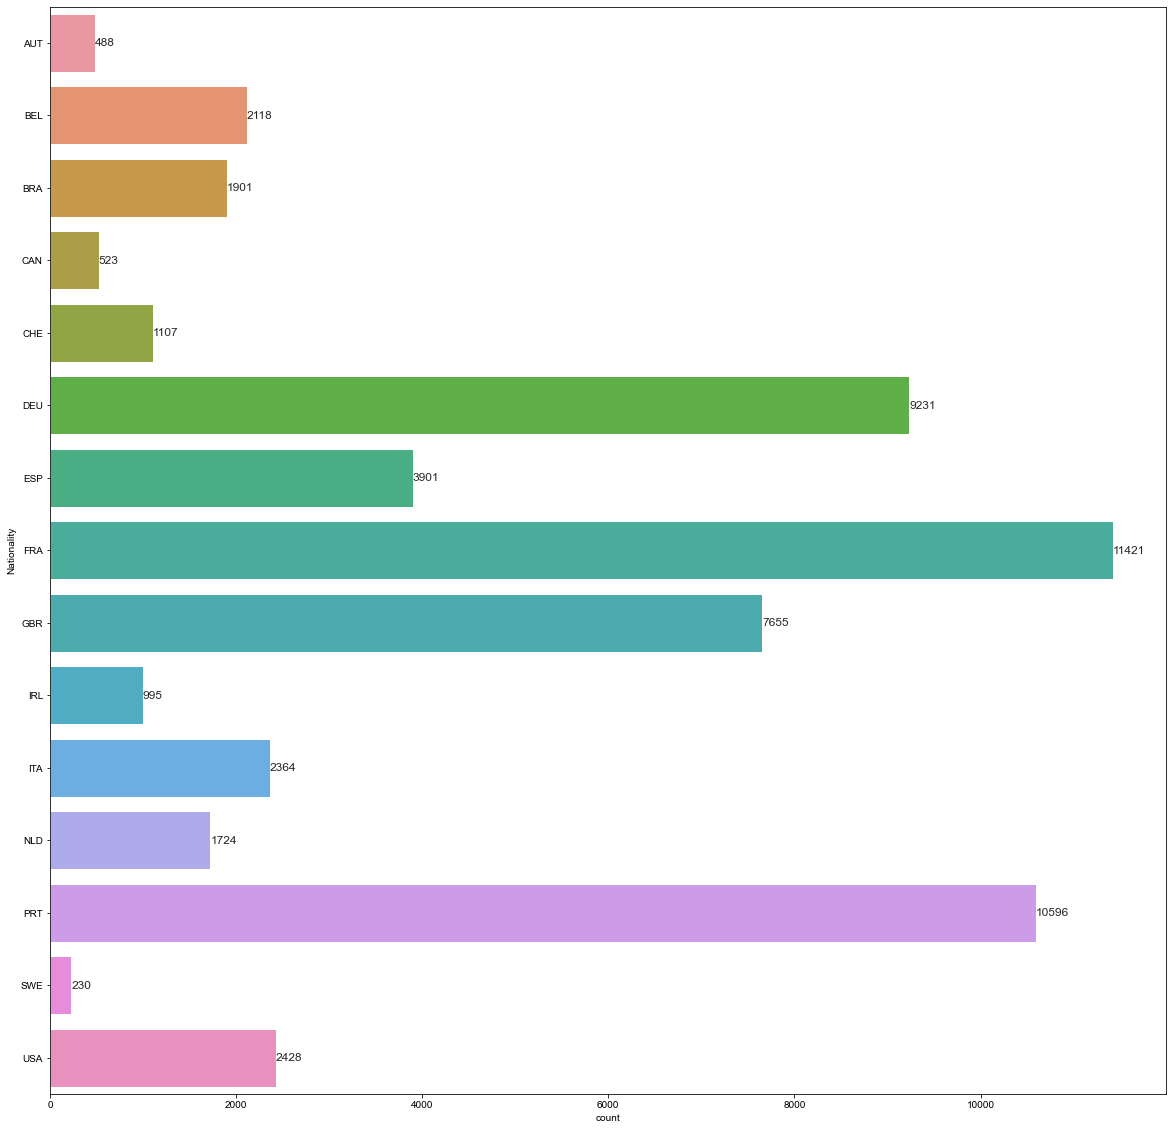

In [14]:
#Visualize the styles and their ratings ocurrance. 
fig, ax = plt.subplots(figsize=(20,20))

Nationalities = top_nationalities.select_dtypes(include = 'object').copy()

#get counts of variables
Nationalities.Nationality.value_counts()

#count plot for one variable
sns.set(rc = {'figure.figsize':(20,30)})
sns.countplot(y= 'Nationality', data = Nationalities)

ax.bar_label(ax.containers[0])

Many of these nationalities are a minor percentage of the total customer base. We can reduce the feature categories by the number of nationaltiies with less than 5% representation to see where that leaves us. This is too many categories to visualize and analyze, we need to reduce the category cardinality in this feature to better work with it moving forward in modeling as well. Dropping customer records are not an option.

Create a new column for \"TopNations\" to group all countries with under 1000 customers into \"Other\" This should give us 16 rather than 188 unique values to visualize and model. We will maintain the original Nationality column in the dataset so the \"Other\" categories can be qurried for their actual country."

In [15]:
TopNation = []

nation_dict = {'AUT': 'AUT', 
                'BEL': 'BEL', 
                'BRA': 'BRA', 
                'CAN': 'CAN', 
                'CHE': 'CHE', 
                'DEU': 'DEU', 
                'ESP': 'ESP', 
                'FRA': 'FRA', 
                'GBR': 'GBR',
                'RL': 'RL',
                'ITA': 'ITA',
                'NLD': 'NLD',
                'PRT': 'PRT',
                'SWE': 'SWE',
                'USA': 'USA'  }

clean_data['Country'] = clean_data['Nationality'].map(nation_dict).fillna('Other')


In [16]:
clean_data.Country.head(100)

0       PRT
1       PRT
2       DEU
3       FRA
4       FRA
      ...  
95      ESP
96      ESP
97      ESP
98      ESP
99    Other
Name: Country, Length: 100, dtype: object

What does the distribution of top nationalities look like?

In [17]:
top_nationalities.describe()

,ID,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
count,56682.000000,56682.000000,56682.000000,56682.000000,56682.000000,56682.000000,56682.000000,56682.000000,56682.000000,56682.000000,...,56682.000000,56682.000000,56682.000000,56682.000000,56682.000000,56682.000000,56682.000000,56682.000000,56682.000000,56682.000000
mean,40468.085618,42.834339,472.256413,68.691101,292.536917,69.848855,0.002435,0.000741,0.809693,4.680445,...,0.000812,0.002629,0.001923,0.013196,0.343425,0.138880,0.000370,0.003528,0.000053,0.086059
std,24469.353978,19.519301,319.267180,91.050456,365.635400,119.120630,0.075098,0.031980,0.748129,4.507534,...,0.028476,0.051204,0.043810,0.114116,0.474856,0.345824,0.019245,0.059296,0.007275,0.280454
min,1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19280.250000,31.000000,185.000000,0.000000,70.400000,4.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39520.500000,45.000000,433.000000,31.000000,230.200000,42.000000,0.000000,0.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,61713.750000,56.000000,761.000000,106.000000,390.600000,90.200000,0.000000,0.000000,1.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,83589.000000,92.000000,1095.000000,588.000000,21781.000000,7730.250000,9.000000,3.000000,66.000000,116.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='Age', ylabel='Nationality'>

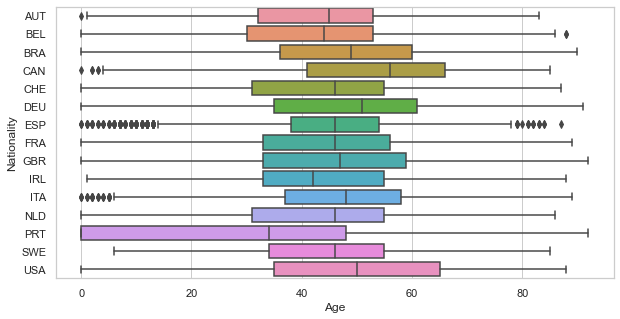

In [18]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='Age', y="Nationality", data=top_nationalities)

<AxesSubplot:xlabel='LodgingRevenue', ylabel='Nationality'>

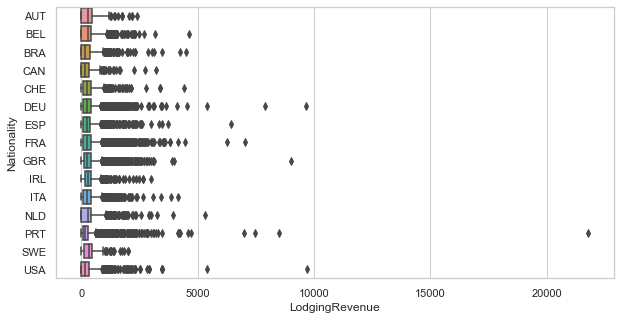

In [19]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='LodgingRevenue', y="Nationality", data=top_nationalities)

<AxesSubplot:xlabel='OtherRevenue', ylabel='Nationality'>

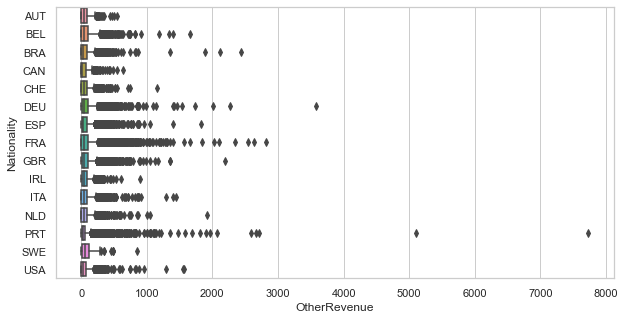

In [20]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='OtherRevenue', y="Nationality", data=top_nationalities)

<AxesSubplot:xlabel='RoomNights', ylabel='Nationality'>

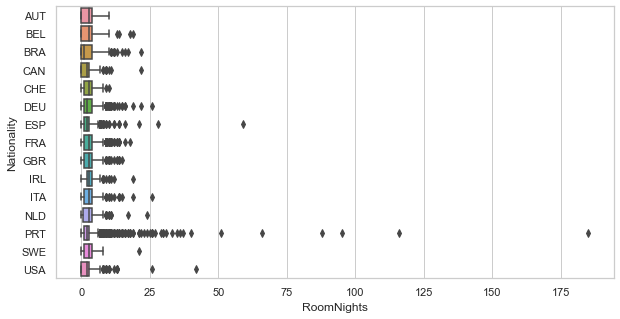

In [21]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='RoomNights', y="Nationality", data=top_nationalities)

<AxesSubplot:xlabel='DaysSinceLastStay', ylabel='Nationality'>

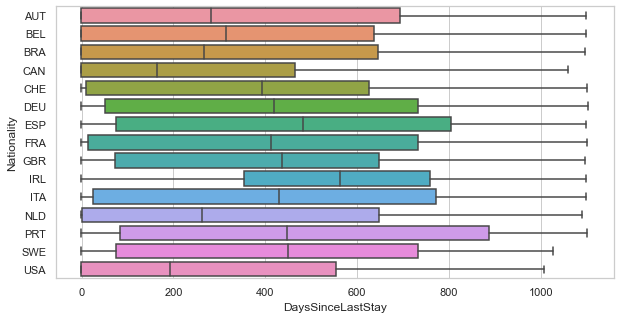

In [22]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='DaysSinceLastStay', y="Nationality", data=top_nationalities)

<AxesSubplot:xlabel='DaysSinceFirstStay', ylabel='Nationality'>

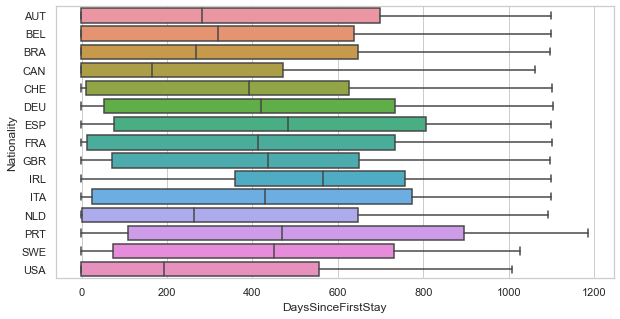

In [23]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='DaysSinceFirstStay', y="Nationality", data=top_nationalities)

### Distribution Channel

Check for imbalance and correlations in the different ways customers make bookings at the hotel. 

Travel Agent/Operator      68569
Direct                     11912
Corporate                   2600
Electronic Distribution      509
Name: DistributionChannel, dtype: int64


<AxesSubplot:xlabel='count', ylabel='DistributionChannel'>

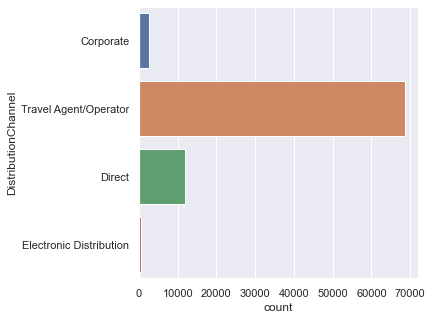

In [24]:
print(clean_data.DistributionChannel.value_counts())


#count plot for one variable
sns.set(rc = {'figure.figsize':(5,5)})
sns.countplot(y= 'DistributionChannel', data = clean_data)

<AxesSubplot:xlabel='Age', ylabel='DistributionChannel'>

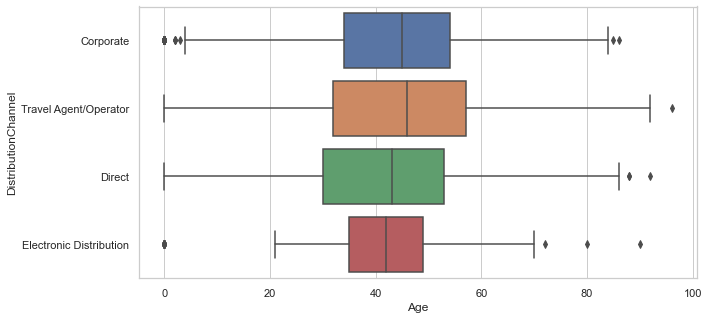

In [25]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='Age', y="DistributionChannel", data=clean_data)

<AxesSubplot:xlabel='LodgingRevenue', ylabel='DistributionChannel'>

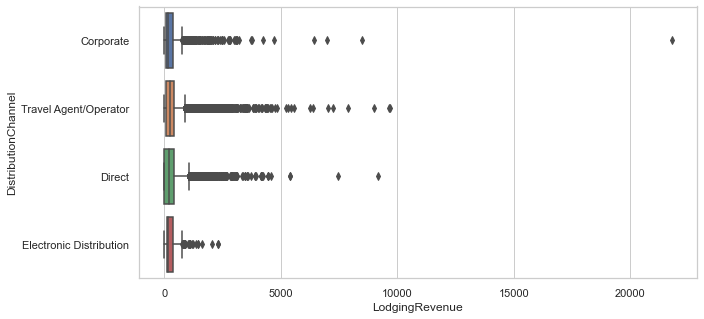

In [26]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='LodgingRevenue', y="DistributionChannel", data=clean_data)

<AxesSubplot:xlabel='OtherRevenue', ylabel='DistributionChannel'>

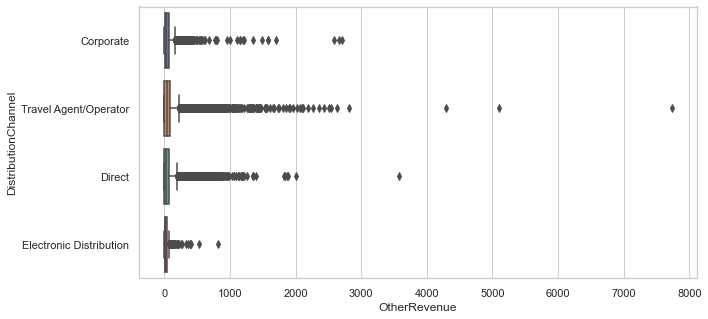

In [27]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='OtherRevenue', y="DistributionChannel", data=clean_data)

<AxesSubplot:xlabel='RoomNights', ylabel='DistributionChannel'>

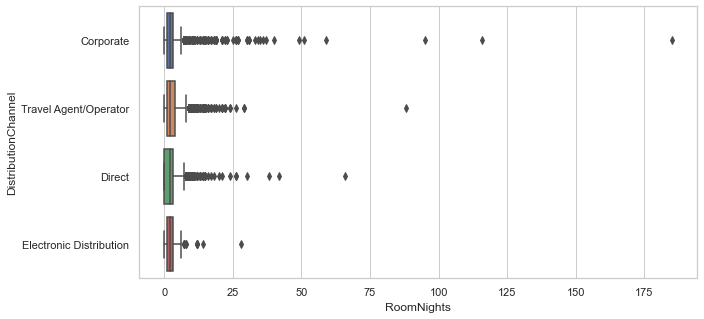

In [28]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='RoomNights', y="DistributionChannel", data=clean_data)

<AxesSubplot:xlabel='DaysSinceLastStay', ylabel='DistributionChannel'>

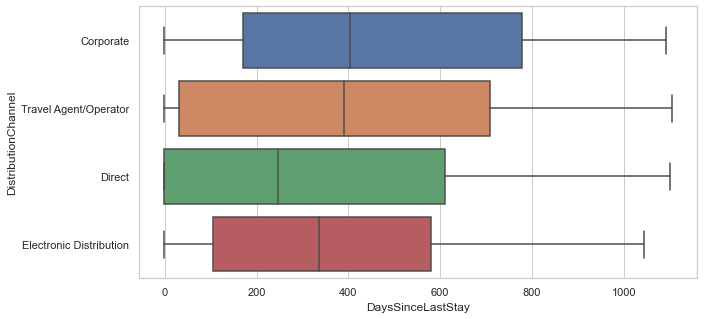

In [29]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='DaysSinceLastStay', y="DistributionChannel", data=clean_data)

<AxesSubplot:xlabel='DaysSinceFirstStay', ylabel='DistributionChannel'>

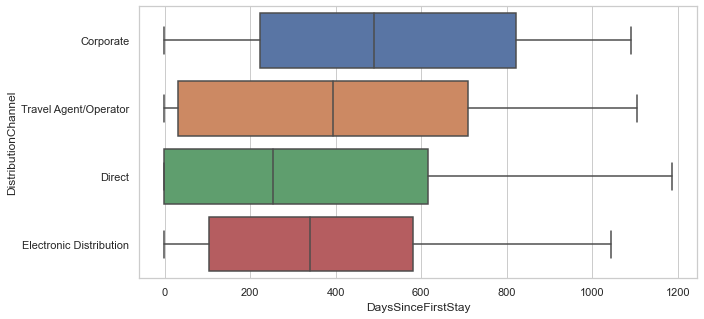

In [30]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='DaysSinceFirstStay', y="DistributionChannel", data=clean_data)

### Marketing Segment

Check for imbalance and correlations in the current market segements customers belong to. 

Other                    48039
Travel Agent/Operator    11670
Direct                   11457
Groups                    9501
Corporate                 2169
Complementary              510
Aviation                   244
Name: MarketSegment, dtype: int64


<AxesSubplot:xlabel='count', ylabel='MarketSegment'>

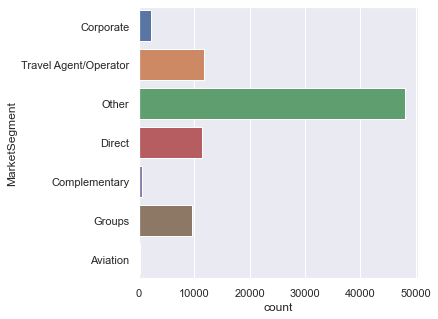

In [31]:
print(clean_data.MarketSegment.value_counts())


#count plot for one variable
sns.set(rc = {'figure.figsize':(5,5)})
sns.countplot(y= 'MarketSegment', data = clean_data)

<AxesSubplot:xlabel='Age', ylabel='MarketSegment'>

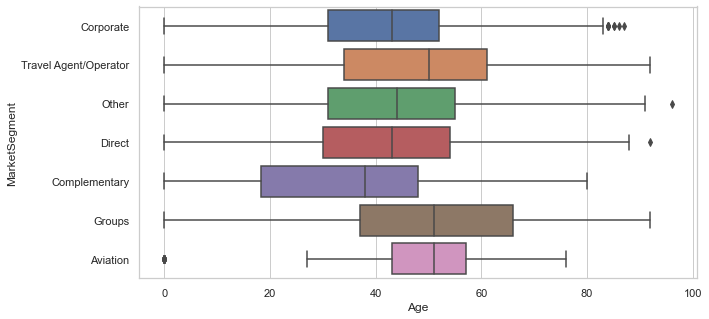

In [32]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='Age', y="MarketSegment", data=clean_data)

<AxesSubplot:xlabel='LodgingRevenue', ylabel='MarketSegment'>

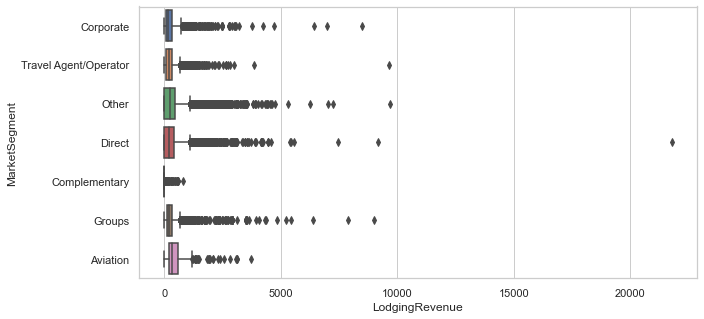

In [33]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='LodgingRevenue', y="MarketSegment", data=clean_data)

<AxesSubplot:xlabel='OtherRevenue', ylabel='MarketSegment'>

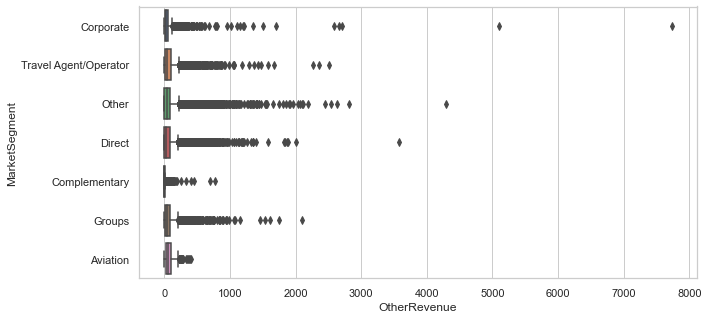

In [34]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='OtherRevenue', y="MarketSegment", data=clean_data)

<AxesSubplot:xlabel='RoomNights', ylabel='MarketSegment'>

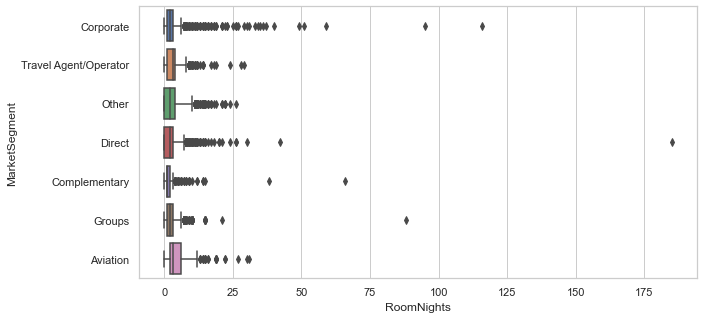

In [35]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='RoomNights', y="MarketSegment", data=clean_data)

<AxesSubplot:xlabel='DaysSinceLastStay', ylabel='MarketSegment'>

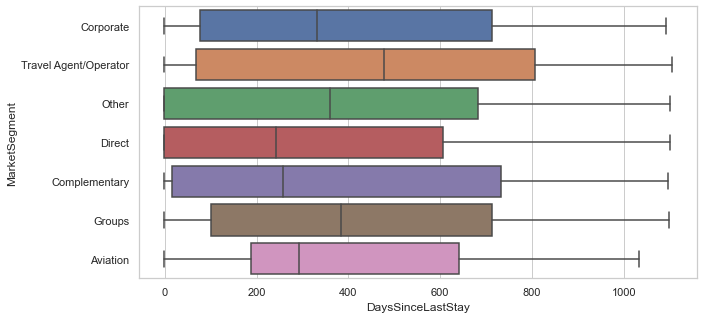

In [36]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='DaysSinceLastStay', y="MarketSegment", data=clean_data)

<AxesSubplot:xlabel='DaysSinceFirstStay', ylabel='MarketSegment'>

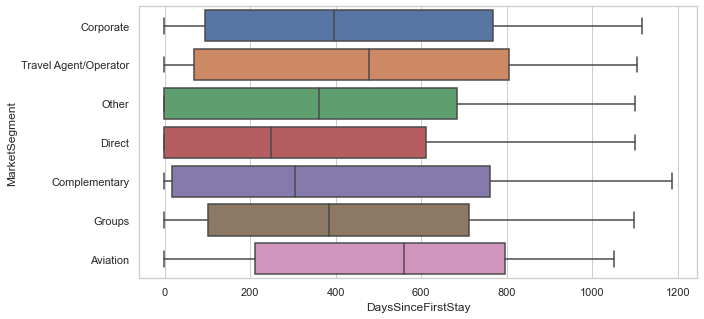

In [37]:
sns.set(rc={"figure.figsize":(10, 5)}, style='whitegrid')

sns.boxplot(x='DaysSinceFirstStay', y="MarketSegment", data=clean_data)

## Numerical Feature Analysis

In [38]:
clean_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,83590.0,41795.500000,24130.498838,1.0,20898.25,41795.5,62692.750,83590.00
Age,83590.0,43.336236,18.728542,0.0,32.00,45.0,56.000,96.00
DaysSinceCreation,83590.0,453.640902,313.390291,0.0,177.00,397.0,723.000,1095.00
AverageLeadTime,83590.0,66.196028,87.758990,-1.0,0.00,29.0,103.000,588.00
LodgingRevenue,83590.0,298.802087,372.851892,0.0,59.00,234.0,402.000,21781.00
OtherRevenue,83590.0,67.589132,114.327776,0.0,2.00,38.5,87.675,7730.25
BookingsCanceled,83590.0,0.002022,0.066770,0.0,0.00,0.0,0.000,9.00
BookingsNoShowed,83590.0,0.000634,0.029545,0.0,0.00,0.0,0.000,3.00
BookingsCheckedIn,83590.0,0.794617,0.695778,0.0,1.00,1.0,1.000,66.00
PersonsNights,83590.0,4.649133,4.567673,0.0,1.00,4.0,6.000,116.00


array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'DaysSinceCreation'}>,
        <AxesSubplot:title={'center':'AverageLeadTime'}>,
        <AxesSubplot:title={'center':'LodgingRevenue'}>],
       [<AxesSubplot:title={'center':'OtherRevenue'}>,
        <AxesSubplot:title={'center':'BookingsCanceled'}>,
        <AxesSubplot:title={'center':'BookingsNoShowed'}>,
        <AxesSubplot:title={'center':'BookingsCheckedIn'}>,
        <AxesSubplot:title={'center':'PersonsNights'}>],
       [<AxesSubplot:title={'center':'RoomNights'}>,
        <AxesSubplot:title={'center':'DaysSinceLastStay'}>,
        <AxesSubplot:title={'center':'DaysSinceFirstStay'}>,
        <AxesSubplot:title={'center':'SRHighFloor'}>,
        <AxesSubplot:title={'center':'SRLowFloor'}>],
       [<AxesSubplot:title={'center':'SRAccessibleRoom'}>,
        <AxesSubplot:title={'center':'SRMediumFloor'}>,
        <AxesSubplot:title={'center':'SRBathtu

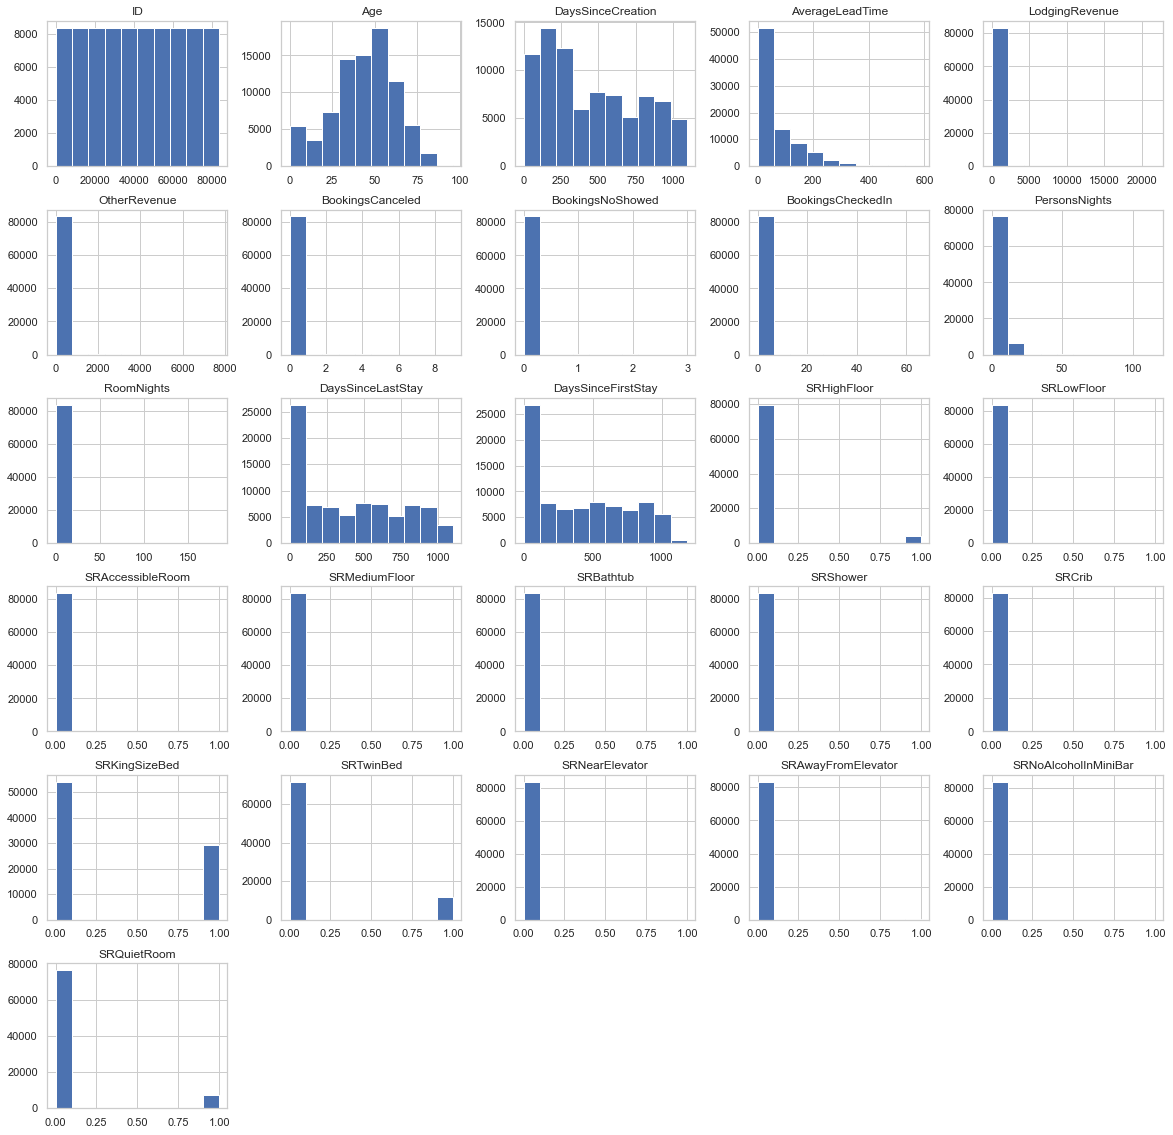

In [39]:
clean_data.hist(figsize=(20,20))

<AxesSubplot:>

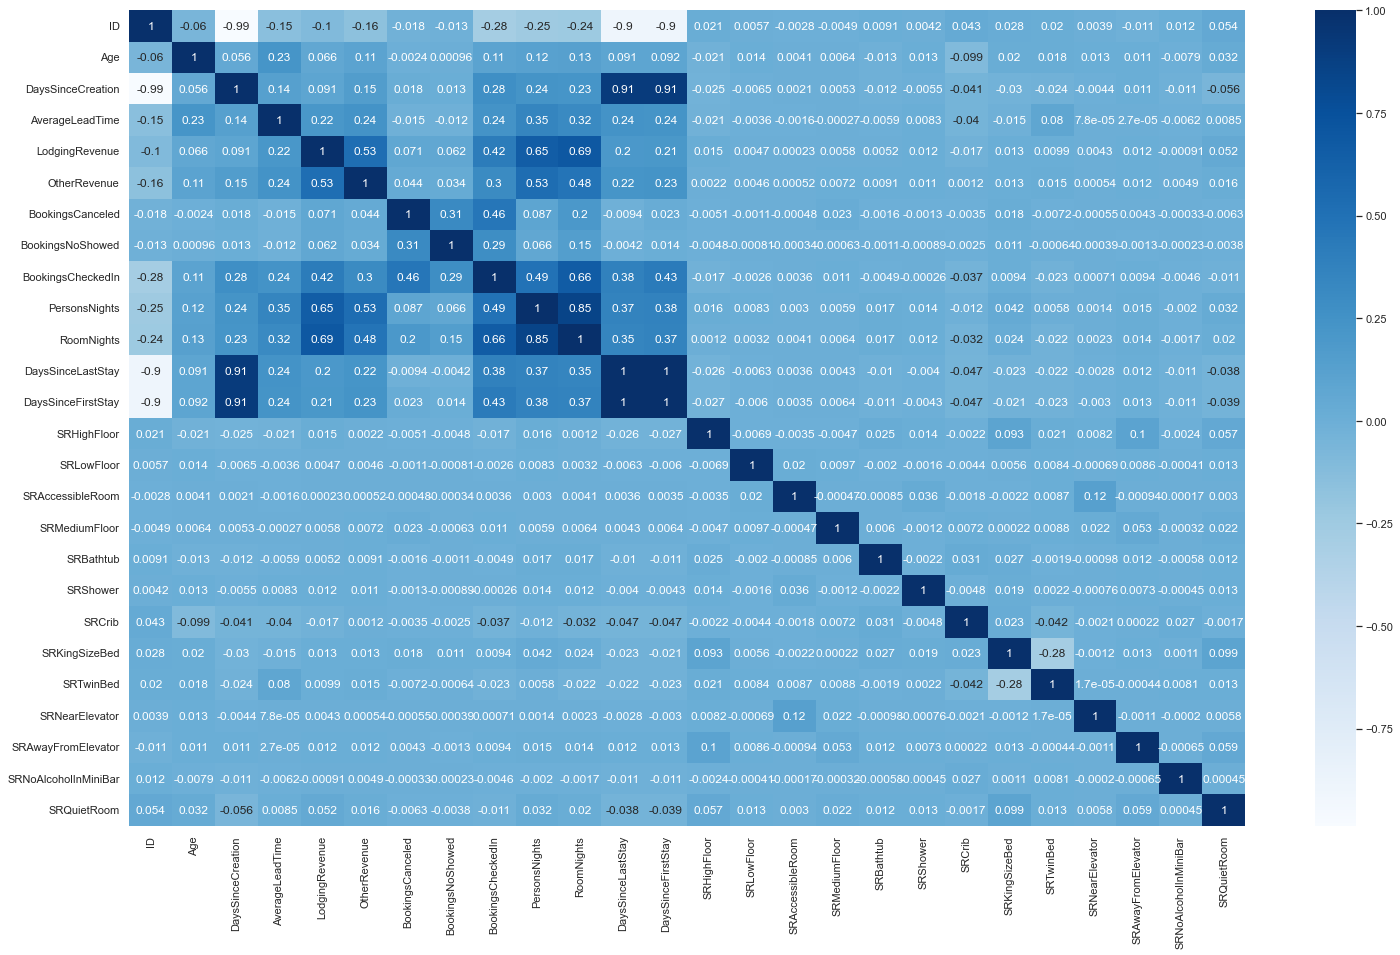

In [40]:
fig, ax = plt.subplots(figsize=(25, 15))

clean_corr = clean_data.corr()
sns.heatmap(clean_corr, cmap="Blues", annot= True,
        xticklabels=clean_corr.columns,
        yticklabels=clean_corr.columns)

No noteworthy correlated numerical pairs to observe unfortunately. 

### Revenues

In [41]:
clean_data['TotalRevenue'] = clean_data['LodgingRevenue'] + clean_data['OtherRevenue']

In [42]:
clean_data.TotalRevenue.head()

0    476.3
1    333.0
2      0.0
3    300.0
4      0.0
Name: TotalRevenue, dtype: float64

Total Revenue for Market Segement

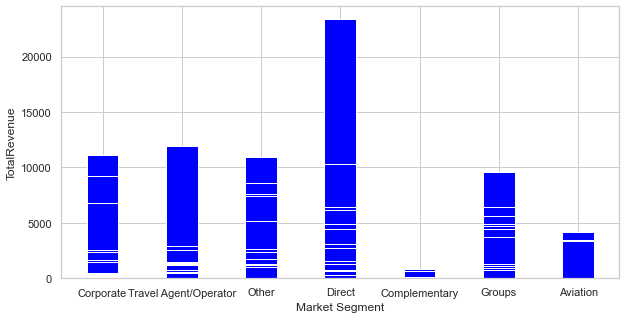

In [43]:
fig = plt.figure(figsize = (10, 5))

plt.bar(clean_data.MarketSegment, clean_data.TotalRevenue, color = 'blue',
        width = .4)

plt.xlabel("Market Segment")
plt.ylabel("TotalRevenue")
plt.show()

Total Revenue for Age

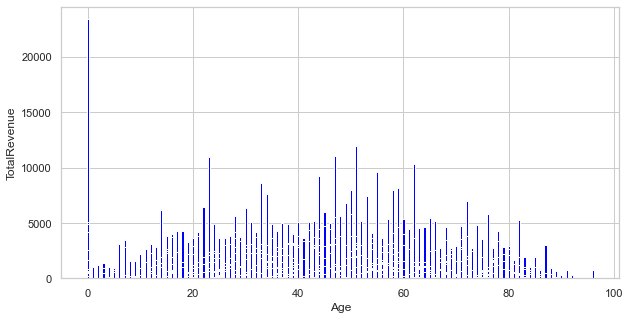

In [44]:
fig = plt.figure(figsize = (10, 5))

plt.bar(clean_data.Age, clean_data.TotalRevenue, color = 'blue',
        width = .4)

bins = (10)

plt.xlabel("Age")
plt.ylabel("TotalRevenue")
plt.show()

Total Revenue for Distribution Channel

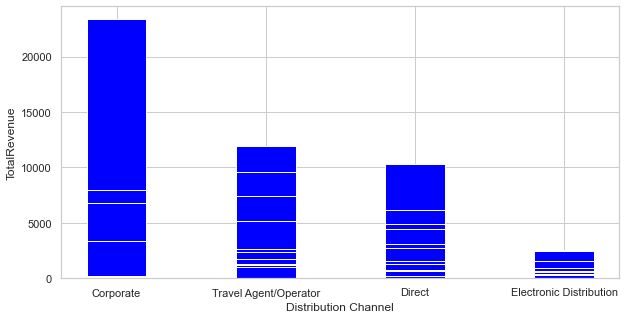

In [45]:
fig = plt.figure(figsize = (10, 5))

plt.bar(clean_data.DistributionChannel, clean_data.TotalRevenue, color = 'blue',
        width = .4)

plt.xlabel("Distribution Channel")
plt.ylabel("TotalRevenue")
plt.show()

Revenue and Country

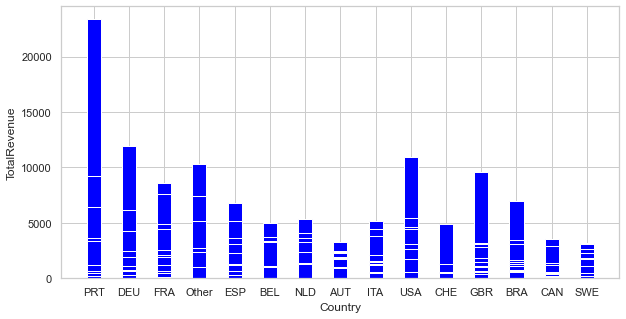

In [46]:
fig = plt.figure(figsize = (10, 5))

plt.bar(clean_data.Country, clean_data.TotalRevenue, color = 'blue',
        width = .4)

plt.xlabel("Country")
plt.ylabel("TotalRevenue")
plt.show()

Average Revenue Per Customer

In [48]:
clean_data['TotalRevenue'].mean()

366.39121892571745

Distribution of new customers. 

<AxesSubplot:>

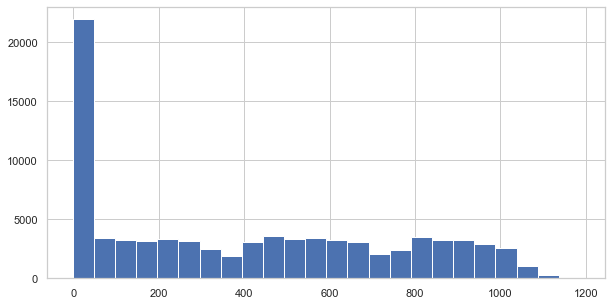

In [49]:
#closer view of this histogram
clean_data['DaysSinceFirstStay'].hist(bins=24)

Average days since confirmed first stay to see the average cusotmer lifetime span. 

In [50]:
clean_data['DaysSinceFirstStay'].mean()

403.3490130398373

Increasing this number would represent loyality and decreasing would indicate more cuosmter aquisition. This should be a metric checked for each business goal. 

## Relationship Analysis

### Pair Plots 

Subset the data into numerical features only. 

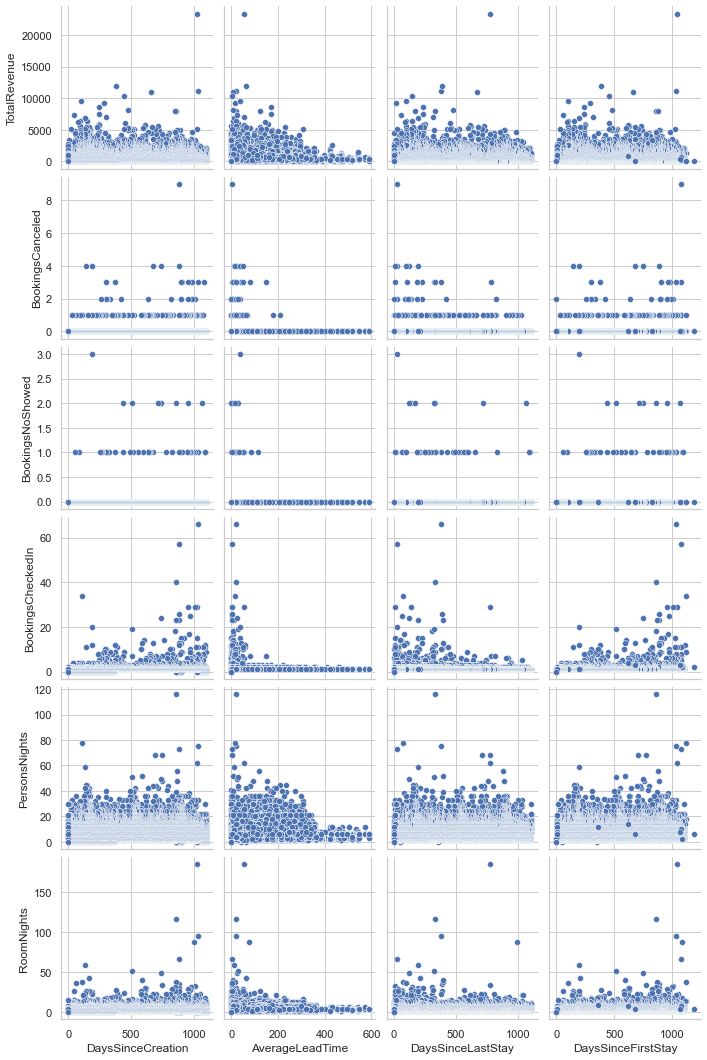

In [51]:
sns.pairplot(
    clean_data,
    x_vars=["DaysSinceCreation", "AverageLeadTime", "DaysSinceLastStay", "DaysSinceFirstStay"],
    y_vars=["TotalRevenue", "BookingsCanceled", "BookingsNoShowed", "BookingsCheckedIn", "PersonsNights", "RoomNights"],)

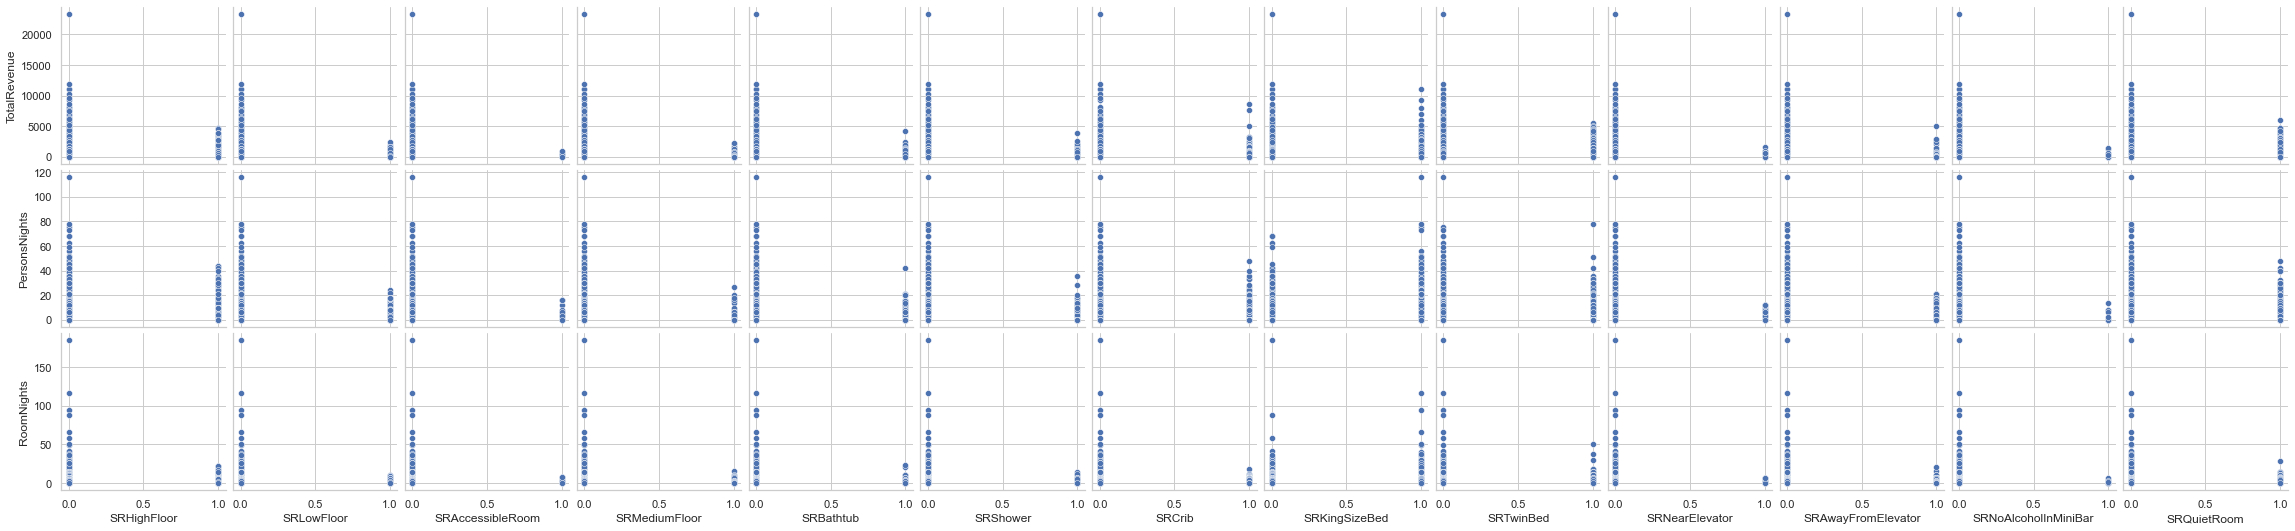

In [52]:
sns.pairplot(
    clean_data,
    x_vars=["SRHighFloor", "SRLowFloor", "SRAccessibleRoom", "SRMediumFloor", "SRBathtub", "SRShower", "SRCrib","SRKingSizeBed", "SRTwinBed", "SRNearElevator", "SRAwayFromElevator", "SRNoAlcoholInMiniBar", "SRQuietRoom"],
    y_vars=["TotalRevenue", "PersonsNights", "RoomNights"],)




## RFM Analysis

The customers are already segmented based on the market into 7 categories with the majority of the customers belonging to an "Other" category. While indicating what domain these customers belong to, the listed market types, the "Other" category could relate to traveling individuals with no known market category and thus shows a need to create one. Or better yet, add another layer of segmentation based on value, demographic, geographic and behavioral personas that will make anticipating and understanding the largest market segment better.  

In order to accomplish this, let's start by seeing how we can create value segments based on common and important business metrics;  recency, frequency and monotary value. By doing this, customer will have a Recency, Frequency and Value scoring that can assist with more detailed segmentation in further.

### Recency

How long has it been since each customer has stayed?

Create a recency dataframe to assign customer recency scores in based on the days since the last stay which are already calculated for us. 

In [53]:
recency = clean_data[['ID','DaysSinceLastStay']]
recency.columns = ['ID', 'Recency']

In [54]:
recency.head()

,ID,Recency
0,1,151
1,2,1100
2,3,-1
3,4,1100
4,5,-1


### Frequency

How often does each customer stay? 

Create a frequency dataframe to store the frequency score based on rooms and nights booked. Total of room/nights the customer stayed at the hotel (checked-in bookings). Room/nights are the multiplication of the number of rooms of each booking by the number of nights of the booking.


In [55]:
frequency = clean_data[['ID','RoomNights']]
frequency.columns = ['ID', 'Frequency']

In [56]:
frequency.head()

,ID,Frequency
0,1,5
1,2,5
2,3,0
3,4,5
4,5,0


### Monetary Value

Monetary Value of the Customer will be based on the total revenue of the customer that is the sum of Lodging and Other revenues. 

In [57]:
monetary = clean_data[['ID','TotalRevenue']]
monetary.columns = ['ID', 'Monetary']

In [58]:
monetary.head()

,ID,Monetary
0,1,476.3
1,2,333.0
2,3,0.0
3,4,300.0
4,5,0.0


Merge all columns into a the rfm dataframe 

In [59]:
rfm = pd.merge(recency, frequency, on='ID', how='inner')
rfm = pd.merge(rfm, monetary, on='ID', how='inner')
rfm.columns = ['ID', 'Recency', 'Frequency', 'Monetary']
rfm

,ID,Recency,Frequency,Monetary
0,1,151,5,476.3
1,2,1100,5,333.0
2,3,-1,0,0.0
3,4,1100,5,300.0
4,5,-1,0,0.0
...,...,...,...,...
83585,83586,-1,0,0.0
83586,83587,3,3,604.6
83587,83588,-1,0,0.0
83588,83589,3,3,990.3


Check rfm variable distribtion 

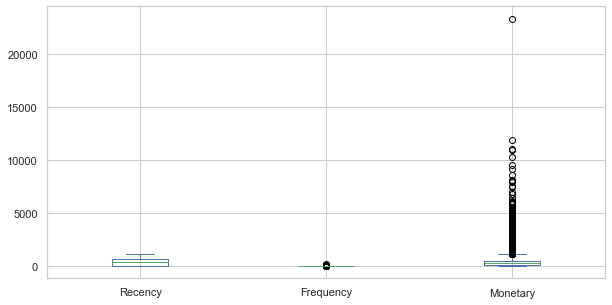

In [60]:
RFMplot = pd.DataFrame(data = rfm, columns = ['Recency','Frequency','Monetary'])

RFMplot.plot(kind='box')
plt.show()

Value ranges are very spread out not aligning well with all the variables. Our dataframe needs normalization so all variables can work on the same scale 

In [61]:
scaler = StandardScaler()

rfm_normalized = rfm[['Recency', 'Frequency', 'Monetary']]

rfm_normalized

,Recency,Frequency,Monetary
0,151,5,476.3
1,1100,5,333.0
2,-1,0,0.0
3,1100,5,300.0
4,-1,0,0.0
...,...,...,...
83585,-1,0,0.0
83586,3,3,604.6
83587,-1,0,0.0
83588,3,3,990.3


In [62]:
rfm_normalized = scaler.fit_transform(rfm_normalized)
rfm_normalized = pd.DataFrame(rfm_normalized)
rfm_normalized

,0,1,2
0,-0.720233,1.157658,0.247655
1,2.013039,1.157658,-0.075240
2,-1.158018,-1.033660,-0.825581
3,2.013039,1.157658,-0.149598
4,-1.158018,-1.033660,-0.825581
...,...,...,...
83585,-1.158018,-1.033660,-0.825581
83586,-1.146497,0.281130,0.536751
83587,-1.158018,-1.033660,-0.825581
83588,-1.146497,0.281130,1.405840


<AxesSubplot:>

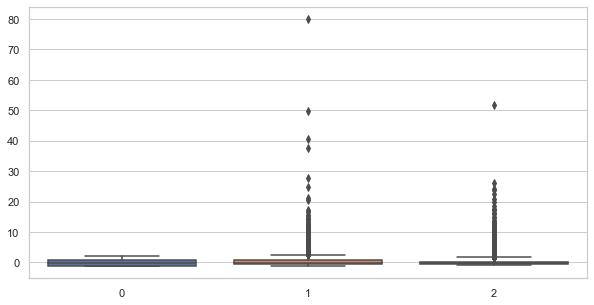

In [63]:
sns.boxplot(data=rfm_normalized)

Merge rfm dataframe into our main customer dataframe to use in Tableau visualization. Our RFM dataframe will be used in the next step to further cluster our customers, try to predict their lifetime value and their churn(cancel or no show) probability. 

In [64]:
hotel_customer_rfm = pd.merge(clean_data, rfm, on='ID', how='inner')

In [67]:
hotel_customer_rfm.head()

,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,...,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom,Country,TotalRevenue,Recency,Frequency,Monetary
0,1,PRT,51.0,150,45,371.0,105.3,1,0,3,...,0,0,0,0,0,PRT,476.3,151,5,476.3
1,2,PRT,0.0,1095,61,280.0,53.0,0,0,1,...,0,0,0,0,0,PRT,333.0,1100,5,333.0
2,3,DEU,31.0,1095,0,0.0,0.0,0,0,0,...,0,0,0,0,0,DEU,0.0,-1,0,0.0
3,4,FRA,60.0,1095,93,240.0,60.0,0,0,1,...,0,0,0,0,0,FRA,300.0,1100,5,300.0
4,5,FRA,51.0,1095,0,0.0,0.0,0,0,0,...,0,0,0,0,0,FRA,0.0,-1,0,0.0


## Data Story

### Create new clean data flat file including transformations made in EDA to use in Tableau analysis. 

In [66]:
file_name = 'Hotel_Customer_RFM.xlsx' 

hotel_customer_rfm.to_excel('Hotel_Customer_RFM.xlsx')


### Visit this further data story analysis on [Tableau Public](https://public.tableau.com/app/profile/lnrobertson/viz/Hotel_Customer_Segmentation/Hotel_Customer_Segmentation?publish=yes)

* Visualizations
* Data Flow Diagrams 
* Business Problem and Solution Process. 